In this notebook we will explore a GPU-accelerated Hierarchical Risk Parity (HRP) portfolio allocation as outlined by Marcos Lopez de Prado in "Building Diversified Portfolios that Outperform Out-of-Sample". Why this allocation? Uses ML techniques to perform better compared to other common techniques such as the Critical Line Algorithm (Markowitz) and the Inverse Variance Portfolio. More information can be found in de Prado's paper. Why does Nvidia care? It will eventually be used as an endpoint for a finance roboadvisor blueprint.

In [1]:
import cudf
import cupy as cp
# Files can be scrapped from github.com/NVIDIA/fsi-samples
m1 = cudf.read_csv("MVO3.2021.11/NASDAQ/prices.csv")
m2 = cudf.read_csv("MVO3.2021.11/NYSE/prices.csv")
m = cudf.concat([m1, m2], axis = 1)
m = m.dropna(axis = 1)
m.head()

,CVLT,IROQ,RCKT,CRVL,HURC,OXBR,LIND,MCFT,USAK,ASET,...,ENBL,GJP,SC,MTR,EDF,IIF,SJM,SR,CMG,DIN
0,58.840000,20.684963,16.070000,67.720001,36.737400,0.93,13.04,25.709999,20.830000,25.409546,...,9.655545,20.146519,17.692389,10.910007,7.899835,19.334360,92.395638,71.196213,490.519989,84.160110
1,58.480000,21.387293,16.170000,68.959999,37.147400,0.94,12.74,25.809999,20.190001,25.381580,...,9.713019,20.146519,17.576107,10.925757,7.841412,19.526201,94.366165,69.752068,482.559998,83.747650
2,58.939999,20.684963,16.110001,69.699997,36.432293,0.90,12.88,25.910000,20.510000,25.362003,...,9.583704,19.828894,17.397215,10.925757,7.821940,19.459473,95.342293,71.223305,473.209991,81.740349
3,58.349998,20.684963,16.030001,70.239998,37.852970,0.92,12.93,26.490000,19.809999,25.484112,...,10.036306,19.837973,17.567162,10.950624,7.899835,19.592928,94.201942,71.430893,475.380005,79.742210
4,56.700001,21.358431,14.990000,65.900002,35.488350,0.90,12.74,24.480000,17.840000,25.120590,...,9.734571,19.765371,16.529591,10.942334,7.880362,19.359381,93.271416,69.824287,468.350006,79.971352


In [2]:
#Split data. 2 years of training, 1 year of testing.
data = m.values
days = data.shape[0]
logRetAll = cp.log(data[1:, :]/data[:-1, :])
moveMask = cp.count_nonzero(logRetAll, axis = 0) > (days * 0.9)  # We require that each security moves day to day at least 90% of the time
positiveMask = data.min(axis = 0) > 0  # Require that all of our data is positive
mask = moveMask & positiveMask
data = data[:, mask]
logRetAll = logRetAll[:, mask]
colNames = m.columns.values.astype('str')
colNames = colNames[mask.get()]

split = int(days*2/3)
train = data[:split, :]
test = data[split:, :]

In [3]:
# Obtain training cov/corr
logRetTrain = logRetAll[:split - 1, :]
corrTrain = cp.corrcoef(logRetTrain, rowvar = False)
covTrain = cp.cov(logRetTrain, rowvar = False) * 252  # Annualized covariance

The goal of the first step of the algorithm is to find the securities which are closely related, and cluster them together. One way to do this is to create a distance metric between each of the securities, and then cluster based on this metric.

In [4]:
#Create distance matrix
D = cp.sqrt(0.5*(1-corrTrain))
print(D.shape[0])

4034


Above is the number of securities we are using for this demonstration.

In [5]:
from cuml import AgglomerativeClustering as AC

#Create single linkage cluster using the Eulclidean metric
def cluster(D):
    model=AC(affinity='l2', connectivity='pairwise', linkage='single', n_clusters=1, output_type = 'cupy')
    model.fit(D);
    return model.children_

A (small) example of what we are doing above is shown below with N=10. Each security is placed in its own cluster. For each iteration of clustering we join the two closest securities into one cluster, and recalculate its distance to the rest of the clusters. This process is repeated until we are left with one cluster.

/tmp/ipykernel_310/846954097.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram(linkage(D[:10,:10].get()))


[]

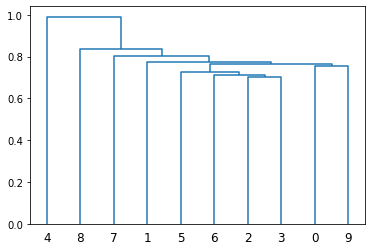

In [6]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
dendrogram(linkage(D[:10,:10].get()))
plt.plot()

Step 2: Reorder the covariance matrix so that similar objects are next to each other (matrix seriation). In this way we are able to quasi-diagonalize the covariance matrix.

In [7]:
def seriation(Z):
    N = Z.shape[1]
    stack = [2*N-2]
    res_order = []
    while(len(stack) != 0):
        cur_idx = stack.pop()
        if cur_idx < N:
            res_order.append(cur_idx)
        else:
            stack.append(int(Z[1, cur_idx-N]))
            stack.append(int(Z[0, cur_idx-N]))
    return res_order

Iterations: 0
102164,171,897,2,0,0
Label prop iterations: 9
Label prop iterations: 2
Iterations: 2
1250,508,299,5,531,1665
Label prop iterations: 11
Label prop iterations: 8
Label prop iterations: 6
Label prop iterations: 3
Iterations: 4
1213,819,534,10,1057,4050
Label prop iterations: 2
Iterations: 1
1060,343,196,3,270,449


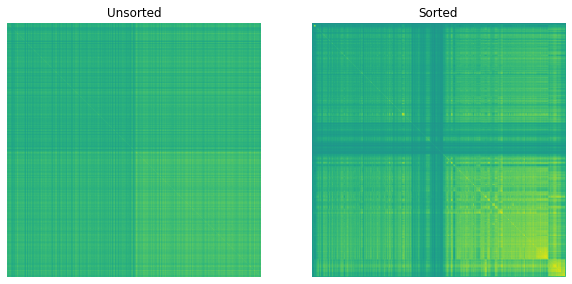

In [8]:
#Plot unsorted / sorted correlation matrices
Z = cluster(D);
res_order = seriation(Z)
fig = plt.figure(figsize = (10, 50))
ax1 = fig.add_subplot(1, 2, 1)
ax1.title.set_text("Unsorted")
ax1.axis("off")
ax1.imshow(corrTrain.get());

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text("Sorted")
ax2.axis("off")
ax2.imshow(corrTrain[:, res_order][res_order, :].get())
plt.plot();

Step 3: assign weights to the securities based on V -- the sorted covariance matrix.

In [9]:
def recursiveBisection(V, l, r, W):
    #Performs recursive bisection weighting for a new portfolio
    
    #V is the sorted correlation matrix
    #l is the left index of the recursion
    #r is the right index of the recursion
    #W is the list of weights
    
    if r-l == 1: #One item
        return W
    else:
        #Split up V matrix
        mid = l+(r-l)//2
        V1 = V[l:mid, l:mid]
        V2 = V[mid:r, mid:r]
        
        #Find new adjusted V
        V1_diag_inv = 1/cp.diag(V1)
        V2_diag_inv = 1/cp.diag(V2)
        w1 = V1_diag_inv/V1_diag_inv.sum()
        w2 = V2_diag_inv/V2_diag_inv.sum()
        V1_adj = w1.T@V1@w1
        V2_adj = w2.T@V2@w2
        
        #Adjust weights
        a2 = V1_adj/(V1_adj+V2_adj)
        a1 = 1-a2
        W[l:mid] = W[l:mid]*a1
        W[mid:r] = W[mid:r]*a2
        W = recursiveBisection(V, l, mid, W)
        W = recursiveBisection(V, mid, r, W)
        return W

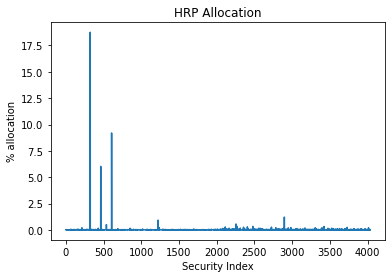

In [10]:
#Obtain the final weights and plot them
N = len(res_order)
V = covTrain[res_order, :][:, res_order]
W_tmp = recursiveBisection(V, 0, N, cp.ones(N))
W = cp.empty(len(W_tmp))
W[res_order] = W_tmp
plt.plot((100*W).get())
plt.xlabel("Security Index")
plt.ylabel("% allocation")
plt.title("HRP Allocation")
plt.plot();

In [11]:
import numpy as np
def plotWeights(colNames, W_old, thres = 0, W_new = None):
    #Displays bar plot for the weights of 1 or 2 portfolio allocations
    
    # colNames is the names of each of the securities in sorted order
    # W_old is the old weighting of the portfolio
    # thres is the threshold for which the allocation of a security must exceed to be shown
    # W_new is the new threshold
    if W_new is None:
        mask = (W_old>thres).get()
        ax=plt.subplot()
        ax.bar(3*np.array(range(len(W_old[mask]))), W_old[mask].get(), tick_label = colNames[mask], align='center')
        ax.set_xticklabels(colNames[mask], rotation = 90)
        plt.xlabel("Securities")
        plt.ylabel("% Allocation")
        plt.title("Allocation of Securities")
    else:
        mask = (cp.maximum(W_new, W_old)>thres).get()
        ax=plt.subplot()
        ax.bar(3*np.array(range(len(W_old[mask])))-0.4, W_new[mask].get())
        ax.bar(3*np.array(range(len(W_old[mask]))), W_old[mask].get(), tick_label = colNames[mask], align='edge')
        ax.set_xticklabels(colNames[mask], rotation = 90)
        ax.legend(["New", "Old"])
        plt.xlabel("Securities")
        plt.ylabel("% allocation relative to original portfolio value")
        plt.title("Allocation of Securities")
    plt.plot();

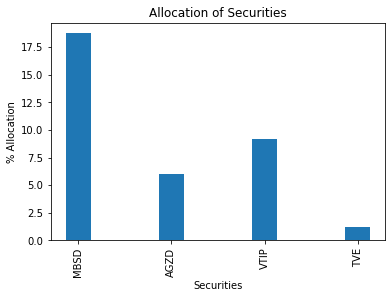

In [12]:
plotWeights(colNames, W*100, thres = 1)

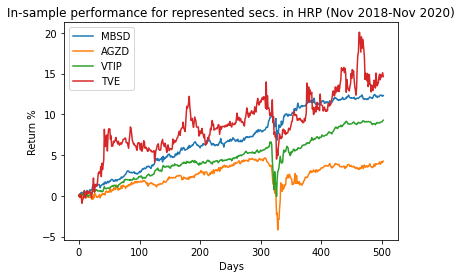

In [13]:
#As a sanity check, we plot the graphs of the securities which were chosen w/ >= 1% allocation over the training period
indices = [i for i, x in enumerate(W>0.01) if x]
for idx in indices:
    plt.plot(100*(-1+train[:, idx]/train[0, idx]).get())
#plt.plot(100*(-1+m.NVDA.to_arrow()[:502]/m.NVDA[0]))
plt.legend(colNames[indices])
plt.xlabel("Days")
plt.ylabel("Return %")
plt.title("In-sample performance for represented secs. in HRP (Nov 2018-Nov 2020)")
plt.plot();

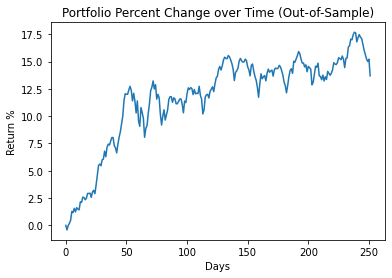

In [14]:
#Plot the OOS performance of the portfolio
perf = cp.empty(test.shape[0])
for day in range(test.shape[0]):
    perf[day] = W.T @ (test[day, :] / test[0, :])
plt.plot(100*(perf-1).get())
plt.xlabel("Days")
plt.ylabel("Return %")
plt.title("Portfolio Percent Change over Time (Out-of-Sample)")
plt.plot();

In [15]:
#Get the statistics of the portfolio
from math import sqrt
logRetTest = logRetAll[split:, :]
covTest = cp.cov(logRetTest, rowvar = False, ddof = 0) * 252  # Annualized
corrTest = cp.corrcoef(logRetTest, rowvar = False)
trainRetAll = cp.sqrt(cp.array(train[-1, :] / train[0, :]))  # Annualized returns
testRetAll = test[-1, :] / test[0, :]
print("Train risk: "+str(sqrt(W@covTrain@W)))
print("Test risk: " + str(sqrt(W@covTest@W)))
print("Train ret: "+ str(W@trainRetAll))
print("Test ret: "+ str(W@testRetAll))

Train risk: 0.1410543777524871
Test risk: 0.07098178153702209
Train ret: 1.0811621038659038
Test ret: 1.137000114159634


In [16]:
# One other thing to check would be to run HRP only on the top performing stocks according to Sharpe ratios. In the below section, we do this for the top 1500(numSharpe) Sharpe ratios.
# Note we also define HRP from separate HRP.py file
from HRP import HRP
from math import sqrt
numSharpe = 1500
trainRiskAll = cp.std(logRetTrain, axis = 0, ddof = 0)*sqrt(252)  # Annualized risk
trainSharpeAll = (trainRetAll-1) / trainRiskAll
W_Sharpe = cp.zeros(len(trainSharpeAll))
mask = cp.argpartition(trainSharpeAll, -numSharpe)[-numSharpe:]
W_Sharpe[mask] = HRP(covTrain[mask, :][:, mask], corrTrain[mask, :][:, mask])
print("Train risk: "+str(sqrt(W_Sharpe@covTrain@W_Sharpe)))
print("Test risk: " + str(sqrt(W_Sharpe@covTest@W_Sharpe)))
print("Train ret: "+ str(W_Sharpe@trainRetAll))
print("Test ret: "+ str(W_Sharpe@testRetAll))

Iterations: 0
8106,214,208,2,0,0
Label prop iterations: 10
Iterations: 1
1216,336,234,4,270,1360
Label prop iterations: 9
Label prop iterations: 5
Label prop iterations: 6
Iterations: 3
1059,638,374,7,815,2989
Label prop iterations: 2
Iterations: 1
1074,314,176,6,269,473
Train risk: 0.09520654386759789
Test risk: 0.046083396401317575
Train ret: 1.1494213482648645
Test ret: 1.081131330615532


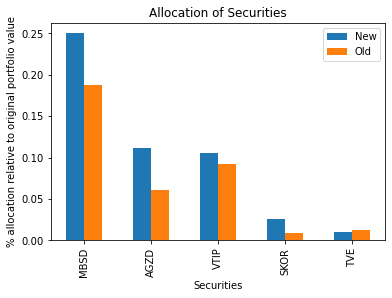

In [17]:
#Compare allocations (old is baseline HRP, new is HRP run only on top Sharpe secs)
plotWeights(colNames, W, thres = 0.01, W_new = W_Sharpe)

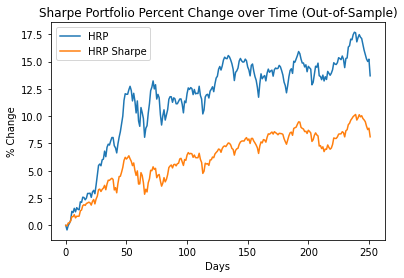

In [18]:
#Check the performances...
perfSharpe = cp.empty(test.shape[0])
for day in range(test.shape[0]):
    perfSharpe[day] = W_Sharpe.T @ (test[day, :] / test[0, :])
plt.plot(100*(perf-1).get())
plt.plot(100*(perfSharpe-1).get())
plt.legend(["HRP", "HRP Sharpe"])
plt.xlabel("Days")
plt.ylabel("% Change")
plt.title("Sharpe Portfolio Percent Change over Time (Out-of-Sample)")
plt.plot();

In [19]:
# Now we wish to find weightings for perfomances we wish to be over a certain threshold

maxReturn = 20
WW = cp.zeros((maxReturn, len(trainRetAll)))
trainRisk = np.empty(maxReturn)
testRisk = np.empty(maxReturn)
trainRet = np.empty(maxReturn)
testRet = np.empty(maxReturn)
testRetAll = test[-1, :] / test[0, :]
for idx, val in enumerate(np.arange(1, 1 + maxReturn/100, 0.01)):
    mask = trainRetAll > val
    W_tmp = HRP(covTrain[mask, :][:, mask], corrTrain[mask, :][:, mask])
    WW[idx, mask] = W_tmp
    trainRisk[idx] = sqrt(W_tmp@covTrain[mask, :][:, mask]@W_tmp)
    testRisk[idx] = sqrt(W_tmp@covTest[mask, :][:, mask]@W_tmp)
    trainRet[idx] = W_tmp@trainRetAll[mask]
    testRet[idx] = W_tmp@testRetAll[mask]


Iterations: 0
48035,254,3318,2,0,0
Label prop iterations: 9
Iterations: 1
1812,541,314,5,433,1544
Label prop iterations: 13
Label prop iterations: 7
Label prop iterations: 8
Label prop iterations: 2
Iterations: 4
1739,1071,617,7,1430,6391
Iterations: 0
13339,201,247,2,0,0
Label prop iterations: 9
Label prop iterations: 2
Iterations: 2
1031,476,325,4,497,1612
Label prop iterations: 13
Label prop iterations: 10
Label prop iterations: 8
Label prop iterations: 2
Iterations: 4
1072,761,560,12,975,5102
Label prop iterations: 2
Iterations: 1
1091,326,189,2,236,462
Iterations: 0
31620,311,1355,3,0,0
Label prop iterations: 10
Iterations: 1
1768,402,314,4,399,2713
Label prop iterations: 10
Label prop iterations: 8
Label prop iterations: 7
Label prop iterations: 2
Iterations: 4
1896,890,781,63,1817,6440
Iterations: 0
30019,262,215,3,0,0
Label prop iterations: 10
Iterations: 1
1085,299,180,4,239,1330
Label prop iterations: 14
Label prop iterations: 8
Label prop iterations: 4
Label prop iterations:

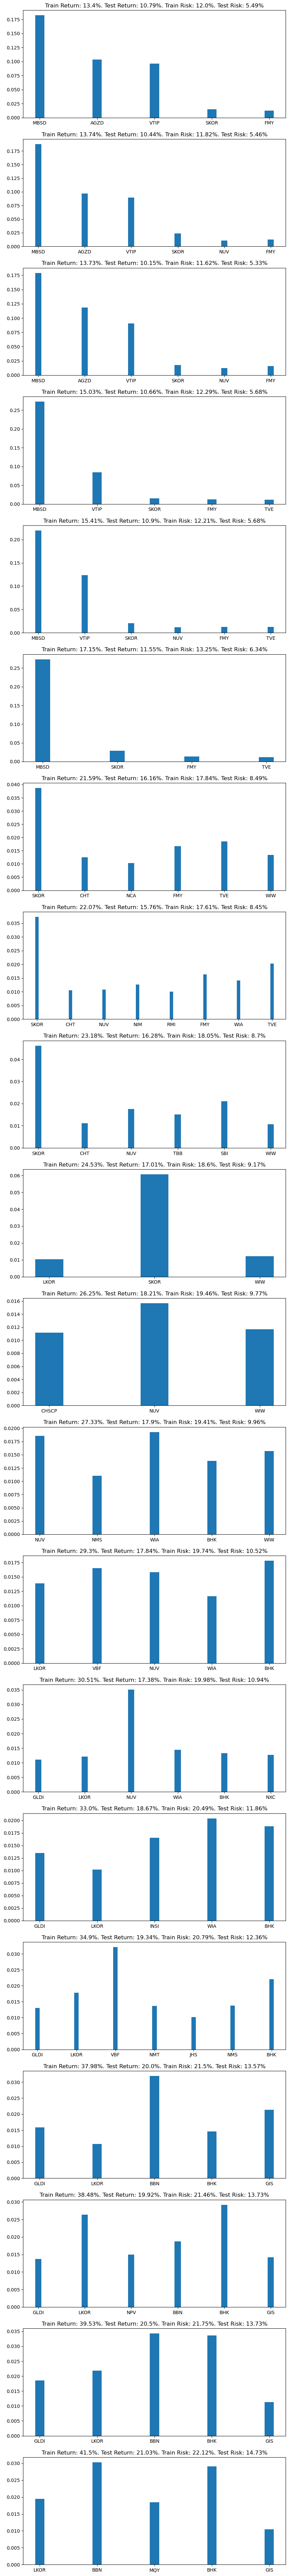

In [20]:
fig = plt.figure(figsize = (10,100), dpi = 100)
for i in range(maxReturn):
    W_tmp = WW[i, :]
    mask = (W_tmp>0.01).get()  # Threshold for how many securities to plot
    ax = fig.add_subplot(20,1,i+1)
    ax.bar(len(W_tmp[mask])*np.array(range(len(W_tmp[mask]))), W_tmp[mask].get(), tick_label = colNames[mask], align='center')
    plt.title("Train Return: "+str(round(100*trainRet[i]-100, 2))+\
        "%. Test Return: "+str(round(100*testRet[i]-100, 2))+\
        "%. Train Risk: "+str(round(100*trainRisk[i], 2))+\
        "%. Test Risk: "+str(round(100*testRisk[i], 2))+"%")
plt.show()

It could be interesting to compare the outputs of HRP to other portfolios. We will check with Markowitz, IVP, and some random portfolios

In [21]:
#RANDOM
def sampleWeight(num_secs, num_pick):
    #sampleWeight allocates a random percentage to a small subset of random stocks in the portfolio.
    
    #num_secs is the number of securities to pick from
    #num_pick is the number of stocks we wish to allocate our portfolio to.
    randW=cp.zeros(num_secs)
    idx = cp.random.choice(num_secs, num_pick, replace = False)
    alloc = cp.random.dirichlet(1, num_pick)
    randW[idx]=alloc
    return randW

In [22]:
nRand = 20
W_rand = cp.empty((nRand, WW.shape[1]))
for i in range(nRand):
    W_rand[i, :] = sampleWeight(WW.shape[1], 15)

In [23]:
#IVP
invVarTrain = 1 / cp.var(logRetTrain, axis = 0, ddof = 0)
W_IVP = invVarTrain / invVarTrain.sum()

In [24]:
from scipy.optimize import *
def MPT(cov, R):
        cons = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, #sum(w)==1",
                {'type': 'ineq', 'fun': lambda x: x}] #each weight >=0 (no short selling)"
        res = minimize(lambda x: -(x@R-1.025)/sqrt(x.T@cov@x), x0=np.ones(len(R))/len(R), constraints=cons) #Minimize risk"
        return res.x

In [25]:
import math
W_MPT = cp.zeros(len(trainRetAll))
# In order to reduce runtime, we only keep stocks w sharpe ratio during training of greater than 1
sharpeTrain = (trainRetAll - 1.025) / (cp.std(logRetTrain, axis = 0, ddof = 1) * math.sqrt(252))  # Annualized sharpe
covnp = covTrain[sharpeTrain > 1, :][:, sharpeTrain > 1].get()  # Numpy version of covariance matrix over training period, masked
Rnp = trainRetAll[sharpeTrain > 1].get()  # Return of all stocks over the training period, masked, in numpy
W_MPT[sharpeTrain > 1] = MPT(covnp, Rnp)


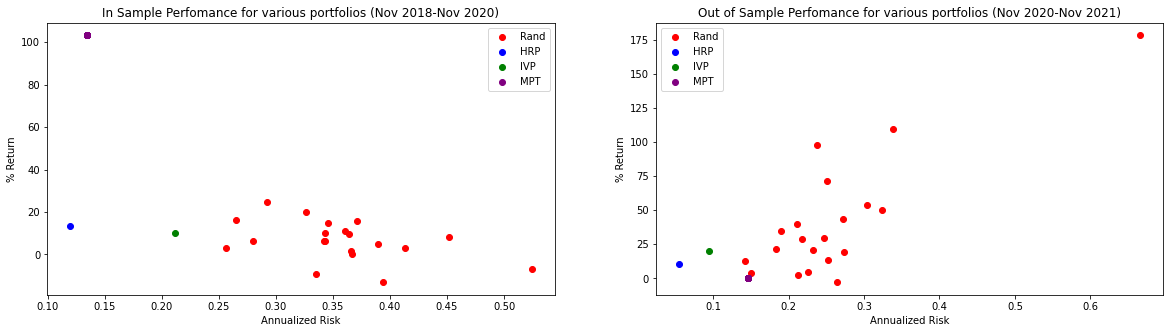

In [26]:
fig = plt.figure(figsize = (20, 5))
ax1 = fig.add_subplot(1, 2, 1)
for i in range(W_rand.shape[0]):  # Plot random portfolios
    l1 = ax1.scatter(sqrt(W_rand[i, :].T@covTrain@W_rand[i, :]),(100*W_rand[i, :].T@trainRetAll-100).get(), c='red', label = 'Rand')
#HRP
l2 = ax1.scatter(trainRisk[0], 100*trainRet[0]-100, c='blue', label='HRP')
#IVP
l3 = ax1.scatter(sqrt(W_IVP.T@covTrain@W_IVP), (100*W_IVP.T@trainRetAll-100).get(), c='green', label='IVP')

for i in range(maxReturn):  #Plot MPT
    l4 = ax1.scatter(sqrt(W_MPT.T@covTrain@W_MPT),(100*W_MPT.T@trainRetAll-100).get(), c='purple', label='MPT')
ax1.legend(handles = [l1, l2, l3, l4])
plt.title("In Sample Perfomance for various portfolios (Nov 2018-Nov 2020)")
plt.xlabel("Annualized Risk")
plt.ylabel("% Return")


ax2 = fig.add_subplot(1, 2, 2)
for i in range(W_rand.shape[0]):  # Plot random portfolios
    l1 = ax2.scatter(sqrt(W_rand[i, :].T@covTest@W_rand[i, :]),(100*W_rand[i, :].T@testRetAll-100).get(), c='red', label = 'Rand')
#HRP
l2 = ax2.scatter(testRisk[0], 100*testRet[0]-100, c='blue', label='HRP')
#IVP
l3 = ax2.scatter(sqrt(W_IVP.T@covTest@W_IVP), (100*W_IVP.T@testRetAll-100).get(), c='green', label='IVP')

for i in range(maxReturn):  #Plot MPT
    l4 = ax2.scatter(sqrt(W_MPT.T@covTest@W_MPT),(100*W_MPT.T@testRetAll-100).get(), c='purple', label='MPT')
ax2.legend(handles = [l1, l2, l3, l4])
plt.title("Out of Sample Perfomance for various portfolios (Nov 2020-Nov 2021)")
plt.xlabel("Annualized Risk")
plt.ylabel("% Return")
plt.show();



In [27]:
# Sharpe ratios
print("HRP train: " + str((trainRet[0] - 1.025)/trainRisk[0]))
print("MPT train: " + str((W_MPT.T@trainRetAll - 1.025)/sqrt(W_MPT.T@covTrain@W_MPT)))
print("HRP test: " + str((testRet[0] - 1.025)/testRisk[0]))
print("MPT test: " + str((W_MPT.T@testRetAll - 1.025)/sqrt(W_MPT.T@covTest@W_MPT)))
print("IVP train: " + str((W_IVP.T@trainRetAll - 1.025)/sqrt(W_IVP.T@covTrain@W_IVP)))
print("IVP test: " + str((W_IVP.T@testRetAll - 1.025)/sqrt(W_IVP.T@covTest@W_IVP)))

HRP train: 0.9083308230716471
MPT train: 7.505250807260351
HRP test: 1.5086982487407843
MPT test: -0.17573787752575742
IVP train: 0.34783317576838496
IVP test: 1.831873385924304


Let's check out runtime comparisons for GPU/CPU performance

In [27]:
logRuntime = logRetAll[:100, :1000]
its = 10
cpu = np.zeros(its)
gpu = np.zeros(its)
size = np.zeros(its)
import time
for i in range(its):
    logLarge = cp.tile(logRuntime, (1, i + 1))
    corr = cp.corrcoef(logLarge, rowvar = False)
    cov = cp.cov(logLarge, rowvar = False) * 252  # Annualized covariance
    size[i] = logLarge.shape[1]
    s = time.time()
    HRP(cov, corr, isGPU = True)
    gpu[i] = time.time() - s
    s = time.time()
    HRP(cov, corr, isGPU = False)
    cpu[i] = time.time() - s


0
Iterations: 0
38308,1725,2414,2,0,0
Label prop iterations: 9
Iterations: 1
9078,771,478,3,1660,4099
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 2
Iterations: 3
6543,2505,2464,5,3420,16630
1
Iterations: 0
38032,221,2440,2,0,0
Label prop iterations: 7
Label prop iterations: 2
Iterations: 2
1653,497,355,3,580,1706
Label prop iterations: 10
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 2
Iterations: 4
2497,922,563,5,1250,5054
Label prop iterations: 2
Iterations: 1
2057,314,224,2,281,627
2
Iterations: 0
18973,171,345,2,0,0
Label prop iterations: 9
Label prop iterations: 2
Iterations: 2
963,393,253,3,417,1359
Label prop iterations: 8
Label prop iterations: 8
Label prop iterations: 7
Label prop iterations: 3
Iterations: 4
875,688,416,5,846,4260
Label prop iterations: 2
Iterations: 1
897,279,159,2,202,401
3
Iterations: 0
28852,277,602,2,0,0
Label prop iterations: 6
Label prop iterations: 2
Iterations: 2
1689,498,261,3,483,1204
Label pro

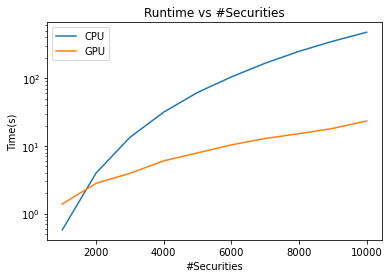

In [28]:
import matplotlib.pyplot as plt

plt.plot(size, cpu)
plt.plot(size, gpu)
plt.legend(["CPU", "GPU"])
plt.title("Runtime vs #Securities")
plt.xlabel("#Securities")
plt.ylabel("Time(s)");
plt.yscale('log')

In [30]:
#Multiples of speed-up for the largest number of securities
print(cpu[-1]/gpu[-1])

20.407641701008885


One other thing that a customer may wish to do is buy/sell stocks as opposed to starting from scratch. The below functions tackle this problem.

In [30]:
def changeAlloc(W, V, allocPer):
    #changeAlloc buys/sells stocks according to the HRP methodology.
    
    #W is the list of weights
    #V is the sorted correlation matrix
    #allocPer is the multiple of the size of portfolio we wish to reach. Ie, if allocPer=0.75, we wish to sell 25% of our stock.
    # If allocPer=1.3, we wish to buy 30% more stock.
             
    def changeRecursiveBisection(V, l, r, W, W_old, allocPer):
        #changeRecursiveBisection performs recursive bisection re-weighting.
        
        #V is the sorted correlation matrix
        #l is the left index of the recursion
        #r is the right index of the recursion
        #W is the list of weights
        #allocPer is the multiple of the size of portfolio we wish to reach. Ie, if allocPer=0.75, we wish to sell 25% of our stock.
        # If allocPer=1.3, we wish to buy 30% more stock.
        if r-l == 1: #One item
            return W
        else:
            #Split up V matrix
            mid = l+(r-l)//2
            V1 = V[l:mid, l:mid]
            V2 = V[mid:r, mid:r]

            #Find new adjusted V
            V1_diag_inv = 1/cp.diag(V1)
            V2_diag_inv = 1/cp.diag(V2)
            w1 = V1_diag_inv/V1_diag_inv.sum()
            w2 = V2_diag_inv/V2_diag_inv.sum()
            V1_adj = w1.T@V1@w1
            V2_adj = w2.T@V2@w2

            #Adjust weights
            a2 = V1_adj/(V1_adj+V2_adj)
            a1 = 1-a2
            lOldSum = W_old[l:mid].sum()
            rOldSum = W_old[mid:r].sum()
            
            # NEW CODE
            
            if allocPer > 1: #buy
                if W[l]*a1 < lOldSum: # Make sure allocation >= than W_old for each sec.
                    a1 = lOldSum/W[l]
                    a2 = 1-a1
                elif W[l]*a2 < rOldSum: # W_new >= than W_old
                    a2 = rOldSum/W[l]
                    a1 = 1-a2
            else: #sell
                if W[l]*a1 > lOldSum: # W_new <= W_old
                    a1 = lOldSum/W[l]
                    a2 = 1-a1
                elif W[l]*a2 > rOldSum:  # W_new <= W_old
                    a2 = rOldSum/W[l]
                    a1 = 1-a2               
                    
            #END NEW CODE
                
            W[l:mid] = W[l:mid]*a1
            W[mid:r] = W[mid:r]*a2
            W = changeRecursiveBisection(V, l, mid, W, W_old, allocPer)
            W = changeRecursiveBisection(V, mid, r, W, W_old, allocPer)
            return W
        
    return changeRecursiveBisection(V, 0, len(W), allocPer*cp.ones(len(W)), W.copy(), allocPer)

In [31]:
W_old = sampleWeight(N, 10)

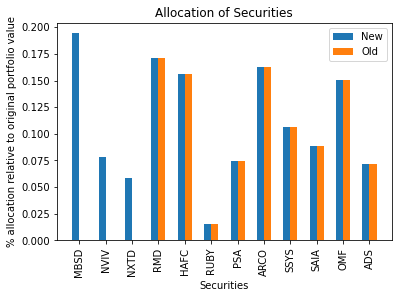

In [35]:
W_new = changeAlloc(W_old, V, 1.5)
plotWeights(m.columns[res_order], W_old, thres = 0.01, W_new = W_new)

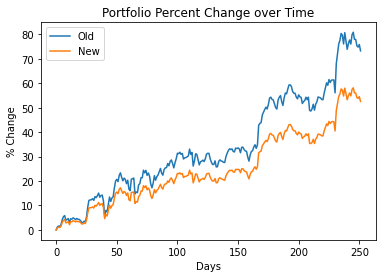

In [39]:
oldVal=np.zeros(test.shape[0])
newVal=np.zeros(test.shape[0])
for day in range(test.shape[0]):
    oldVal[day] = (float(np.dot(W_old, test[day, :][res_order])))
    newVal[day] = (float(np.dot(W_new, test[day, :][res_order])))
plt.plot(100*np.array(oldVal)/oldVal[0]-100)
plt.plot(100*np.array(newVal)/newVal[0]-100)
plt.legend(['Old', 'New'])
plt.xlabel("Days")
plt.ylabel("% Change")
plt.title("Portfolio Percent Change over Time");